In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import collections
import random
import re
import time
import json
import pickle
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.io import imread_collection
from glob import glob
from PIL import Image

In [2]:
data_dir = "data/train/"

In [3]:
tf.__version__

'2.3.0'

In [4]:
batch_size = 16
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 4 classes.
Using 14498 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 4 classes.
Using 8698 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 4 classes.
Using 5799 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['peinture', 'photo', 'sketch', 'text']


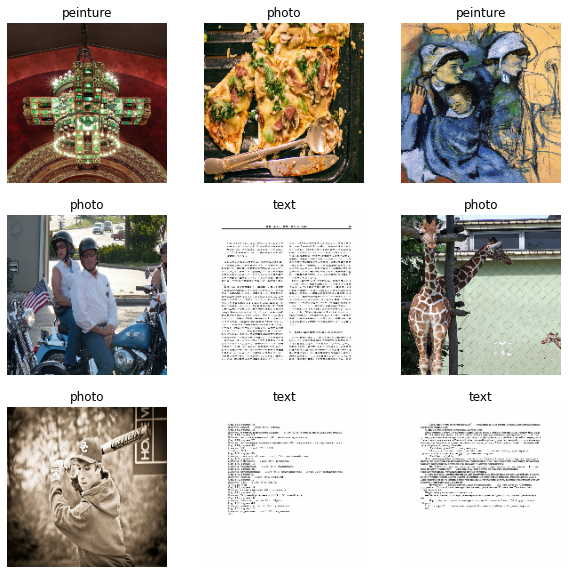

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 180, 180, 3)
(16,)


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.030762559 1.0


In [14]:
num_classes = 4

modelFinal = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(3, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [15]:
modelFinal.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
modelFinal.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [17]:
epochs=10
history = modelFinal.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
907/907 [==============================] - 71s 78ms/step - loss: 0.4491 - accuracy: 0.7745 - val_loss: 0.4334 - val_accuracy: 0.8082
Epoch 2/10
907/907 [==============================] - 22s 25ms/step - loss: 0.3289 - accuracy: 0.8463 - val_loss: 0.3491 - val_accuracy: 0.8372
Epoch 3/10
907/907 [==============================] - 22s 24ms/step - loss: 0.2900 - accuracy: 0.8698 - val_loss: 0.2987 - val_accuracy: 0.8687
Epoch 4/10
907/907 [==============================] - 22s 24ms/step - loss: 0.2673 - accuracy: 0.8841 - val_loss: 0.2573 - val_accuracy: 0.8895
Epoch 5/10
907/907 [==============================] - 22s 24ms/step - loss: 0.2358 - accuracy: 0.8952 - val_loss: 0.2570 - val_accuracy: 0.8863
Epoch 6/10
907/907 [==============================] - 22s 24ms/step - loss: 0.2160 - accuracy: 0.9082 - val_loss: 0.2354 - val_accuracy: 0.8996
Epoch 7/10
907/907 [==============================] - 22s 24ms/step - loss: 0.2019 - accuracy: 0.9150 - val_loss: 0.2343 - val_accuracy:

In [19]:
modelFinal.save('saved_model/modelFinal')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/modelFinal\assets


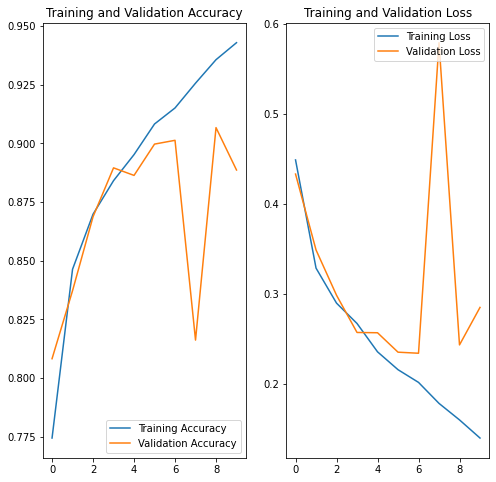

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [60]:
dataTest = imread_collection('data/test/*.jpg')

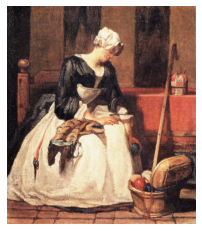

In [85]:
imgModif = cv2.resize(dataTest[1],(180,180))
imgModif = np.reshape(imgModif,[1,180,180,3])

plt.axis("off")
plt.imshow(dataTest[1])
plt.show()

In [86]:
predictions = probability_model.predict(imgModif)

In [87]:
class_names[np.argmax(predictions[0])]

'peinture'